#Customer Segmentation in E-Commerce

#Project Overview
In this project, we perform **Customer Segmentation** using **RFM Analysis (Recency, Frequency, Monetary)** and apply **Machine Learning techniques** to group customers based on their shopping behavior.

##Objectives
**Segment customers into meaningful groups**  
**Analyze customer purchase behavior using RFM**  
**Apply K-Means, Hierarchical, and DBSCAN Clustering**  
**Predict customer churn using Machine Learning**  
**Identify business strategies based on segmentation insights**

##Dataset Description
The dataset contains **customer purchase history**, including:
- **InvoiceNo**: Unique ID for each transaction  
- **CustomerID**: Unique identifier for customers  
- **Quantity**: Number of items purchased  
- **UnitPrice**: Price per item  
- **InvoiceDate**: Date of purchase  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data.csv", encoding='ISO-8859-1')  # Use correct encoding

# Remove rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Remove duplicate rows
df = df.drop_duplicates()

# Remove rows with negative Quantity and UnitPrice
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]


# Convert CustomerID to integer (if needed)
df["CustomerID"] = df["CustomerID"].astype(int)

from google.colab import drive

# Mount Google Drive (only needs to be done once per session)
drive.mount('/content/drive')

# Save cleaned data permanently to Google Drive
df.to_csv("/content/drive/My Drive/cleaned_data.csv", index=False)

# Display summary statistics
df.describe()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


#Data Preprocessing & Cleaning

##Why Data Cleaning?
Before analysis, we need to **clean the dataset** to:
Remove missing values  
Handle duplicate transactions  
Convert data types  
Ensure data consistency  

##Steps Performed:
**Removed null `CustomerID` values**  
**Dropped duplicate records**  
**Filtered out negative `Quantity` and `UnitPrice` values**  
**Created `TotalSpend` feature (`Quantity * UnitPrice`)**

#Exploratory Data Analysis (EDA)

##Why EDA?
Exploratory Data Analysis helps us **understand customer spending behavior** before applying segmentation techniques.

##Steps Performed:
**Summary statistics** of purchases  
**Distribution of `TotalSpend`** (log-transformed to handle outliers)  
**Top 10 best-selling products**  
**Customer spending trends visualization**

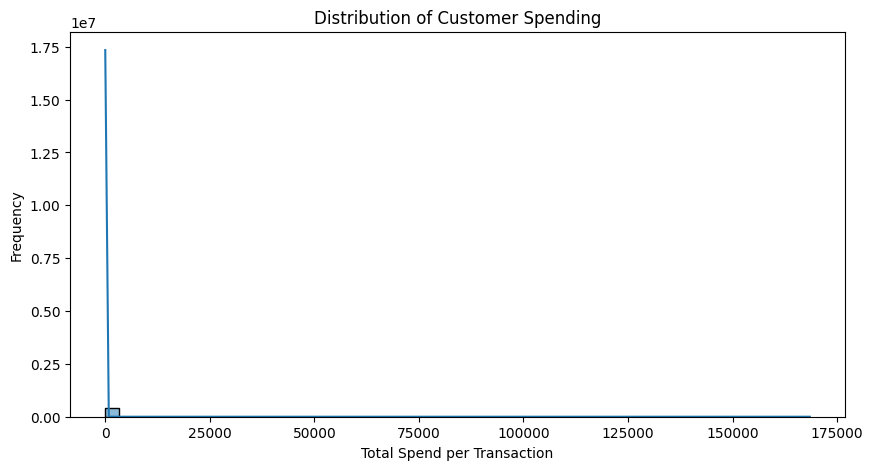

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for Total Spend
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Plot distribution of spending
plt.figure(figsize=(10,5))
sns.histplot(df['TotalSpend'], bins=50, kde=True)
plt.title("Distribution of Customer Spending")
plt.xlabel("Total Spend per Transaction")
plt.ylabel("Frequency")
plt.show()


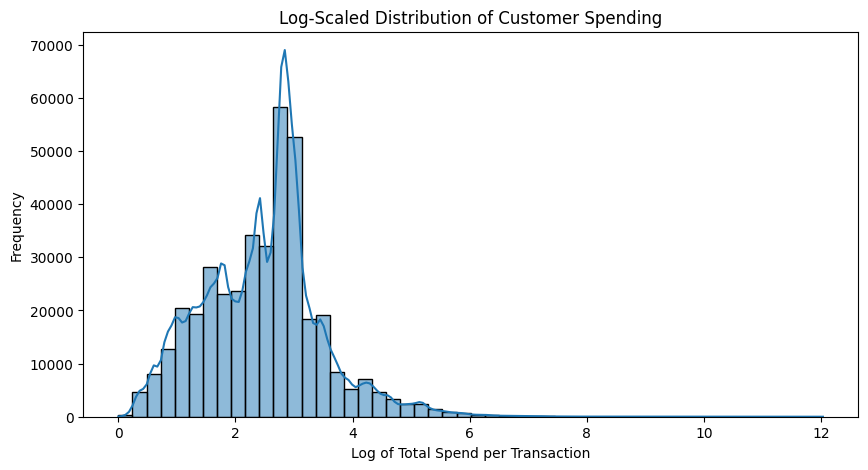

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation (avoid log(0) error by adding 1)
df['LogTotalSpend'] = np.log1p(df['TotalSpend'])

# Plot log-transformed spending distribution
plt.figure(figsize=(10,5))
sns.histplot(df['LogTotalSpend'], bins=50, kde=True)
plt.title("Log-Scaled Distribution of Customer Spending")
plt.xlabel("Log of Total Spend per Transaction")
plt.ylabel("Frequency")
plt.show()



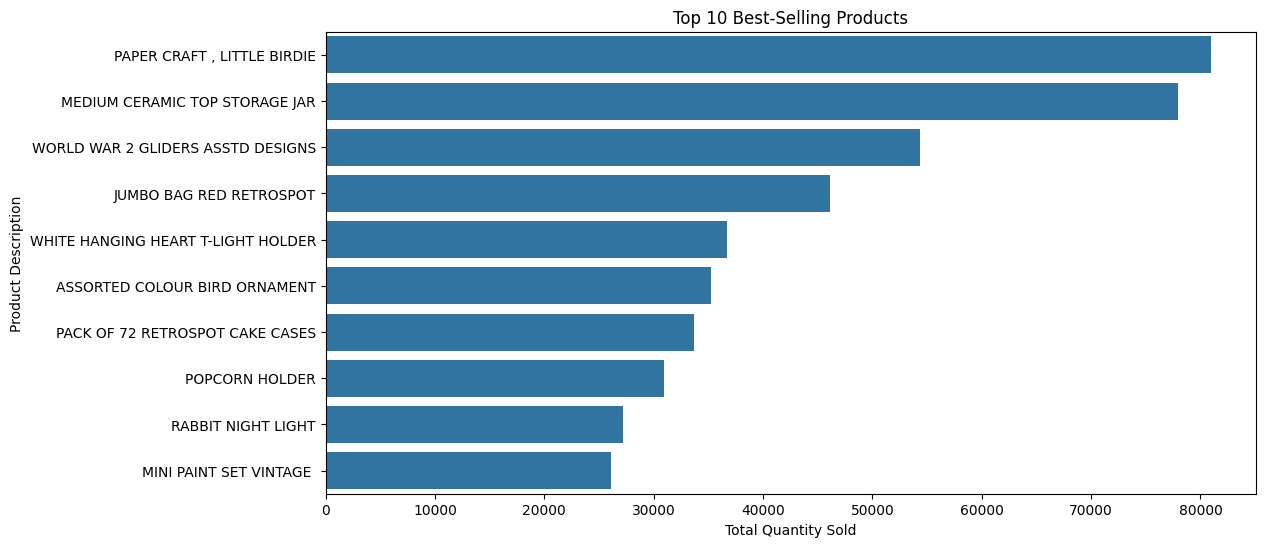

In [ ]:
# Get top 10 selling products
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()


#RFM Analysis (Recency, Frequency, Monetary)

##What is RFM?
RFM Analysis is used to **understand customer purchase behavior** based on:
**Recency (R)** → Days since last purchase  
**Frequency (F)** → Total number of purchases  
**Monetary (M)** → Total amount spent  

##Why RFM?
By scoring customers based on RFM, businesses can:
- **Identify high-value customers** for special promotions  
- **Detect inactive customers** for re-engagement strategies  
- **Segment customers for personalized marketing**

In [ ]:
import datetime as dt

# Convert InvoiceDate to datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Get the latest date in the dataset + 1 day
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm_df = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",  # Frequency
    "TotalSpend": "sum"  # Monetary
})

# Rename columns
rfm_df.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalSpend": "Monetary"
}, inplace=True)

# Display first 5 rows
rfm_df.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [ ]:
# Assign RFM scores (1 to 5)
rfm_df["R_Score"] = pd.qcut(rfm_df["Recency"], q=5, labels=[5, 4, 3, 2, 1])  # Lower Recency is better
rfm_df["F_Score"] = pd.cut(rfm_df["Frequency"], bins=[0,1,2,5,10,1000], labels=[1,2,3,4,5], include_lowest=True)  # Manual binning
rfm_df["M_Score"] = pd.qcut(rfm_df["Monetary"], q=5, labels=[1, 2, 3, 4, 5])  # Higher Monetary is better

# Create final RFM Score
rfm_df["RFM_Score"] = rfm_df["R_Score"].astype(str) + rfm_df["F_Score"].astype(str) + rfm_df["M_Score"].astype(str)

# Display first few rows
rfm_df.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,5,115
12347,2,7,4310.00,5,4,5,545
12348,75,4,1797.24,2,3,4,234
12349,19,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [ ]:
# Define function to assign RFM segments
def assign_segment(rfm_score):
    if rfm_score in ['555', '545', '554']:
        return 'Best Customers'
    elif rfm_score in ['543', '535', '533']:
        return 'Loyal Customers'
    elif rfm_score in ['155', '144', '133']:
        return 'Churn Risk'
    elif rfm_score in ['511', '422', '311']:
        return 'Potential Customers'
    elif rfm_score in ['111', '112', '121']:
        return 'Lost Customers'
    elif rfm_score in ['451', '352', '451']:
        return 'Big Spenders'
    else:
        return 'Regular Customers'

# Apply the segmentation function
rfm_df["Segment"] = rfm_df["RFM_Score"].apply(assign_segment)

# Display first few rows
rfm_df.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Regular Customers
12347,2,7,4310.00,5,4,5,545,Best Customers
12348,75,4,1797.24,2,3,4,234,Regular Customers
12349,19,1,1757.55,4,1,4,414,Regular Customers
12350,310,1,334.40,1,1,2,112,Lost Customers


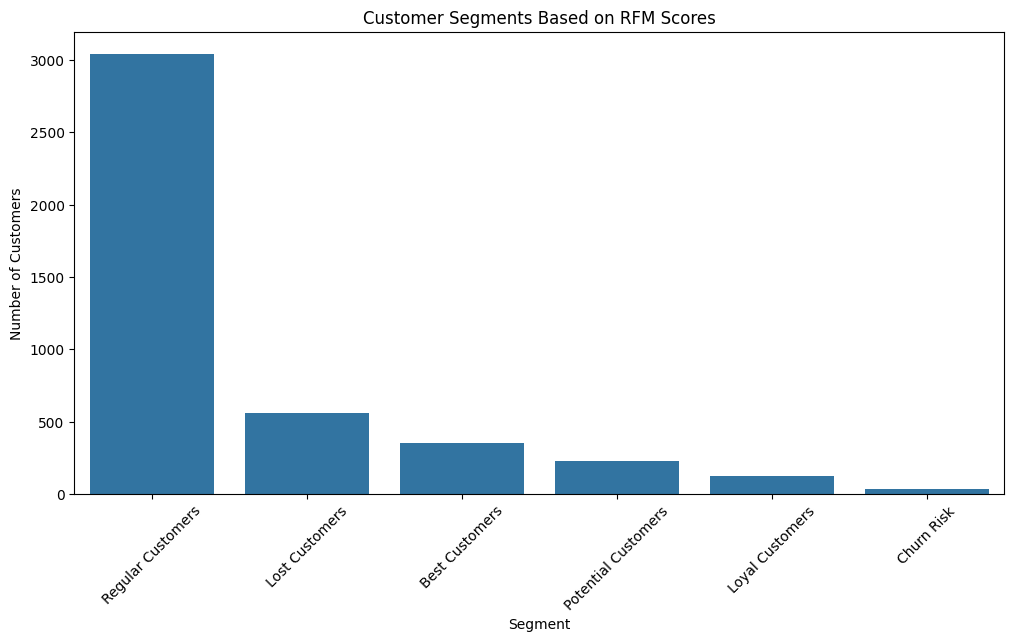

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot of customer segments
plt.figure(figsize=(12, 6))
sns.countplot(x=rfm_df["Segment"], order=rfm_df["Segment"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Customer Segments Based on RFM Scores")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Standardize (scale) the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for better visualization
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Display first few rows
rfm_scaled_df.head()


,Recency,Frequency,Monetary
0,2.334574,-0.425097,8.363010
1,-0.905340,0.354417,0.251699
2,-0.175360,-0.035340,-0.027988
3,-0.735345,-0.425097,-0.032406
4,2.174578,-0.425097,-0.190812


#Customer Segmentation using K-Means Clustering

##Why K-Means?
K-Means is an unsupervised ML algorithm that helps group customers into **K segments** based on their RFM scores.

##Steps Performed:
Used the **Elbow Method** to find the optimal `K`  
Applied **K-Means clustering on scaled RFM values**  
Visualized **customer segments**  
Extracted **business insights from clusters**

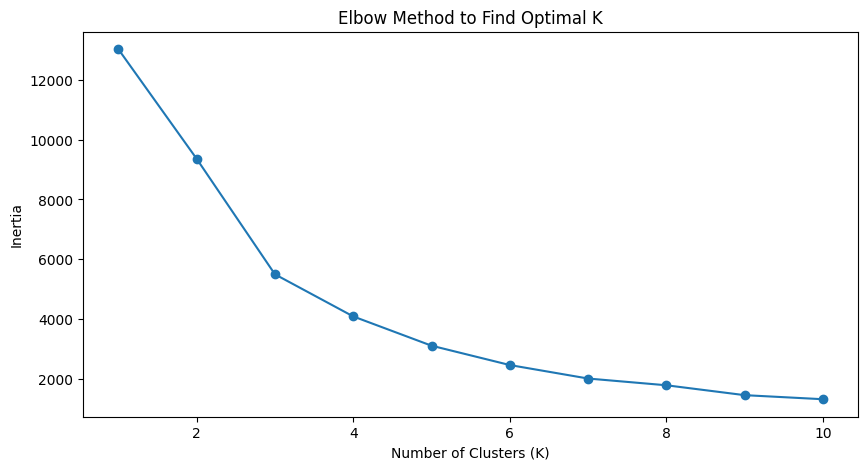

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Find optimal K using inertia
inertia = []
K_range = range(1, 11)  # Checking clusters from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal K')
plt.show()


In [ ]:
# Import KMeans
from sklearn.cluster import KMeans

# Apply K-Means with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Display first few rows with clusters
rfm_df.head()




,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Regular Customers,1
12347,2,7,4310.00,5,4,5,545,Best Customers,0
12348,75,4,1797.24,2,3,4,234,Regular Customers,0
12349,19,1,1757.55,4,1,4,414,Regular Customers,0
12350,310,1,334.40,1,1,2,112,Lost Customers,1


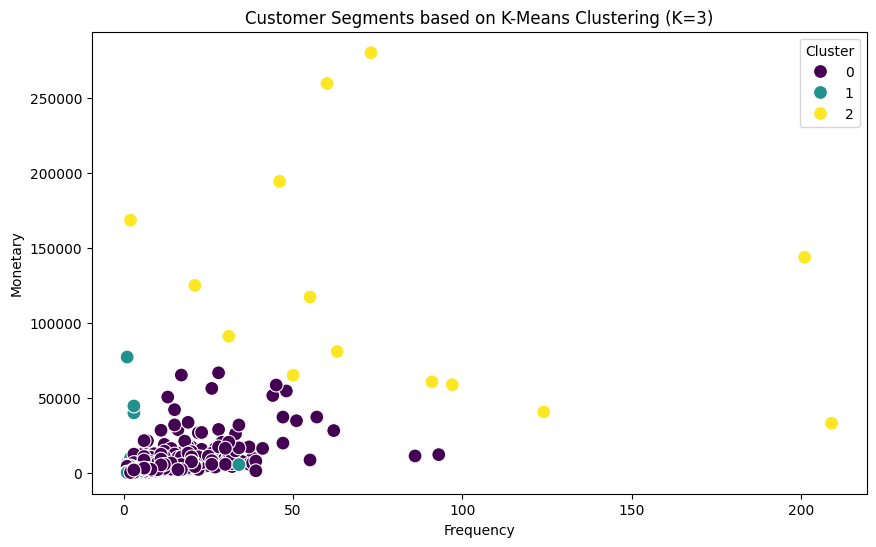

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of clusters based on Frequency & Monetary
plt.figure(figsize=(10,6))
sns.scatterplot(x=rfm_df["Frequency"], y=rfm_df["Monetary"], hue=rfm_df["Cluster"], palette="viridis", s=100)
plt.title("Customer Segments based on K-Means Clustering (K=3)")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.show()


#Hierarchical Clustering for Customer Segmentation

##Why Hierarchical Clustering?
Unlike K-Means, **Hierarchical Clustering** builds a tree-like structure that:
Helps visualize relationships between customers  
Works well when the number of clusters is unknown  
Is useful for small datasets where K-Means struggles  

##Steps Performed:
**Generated Dendrogram to determine cluster groups**  
**Applied Agglomerative Clustering (n=3)**  
**Compared results with K-Means**

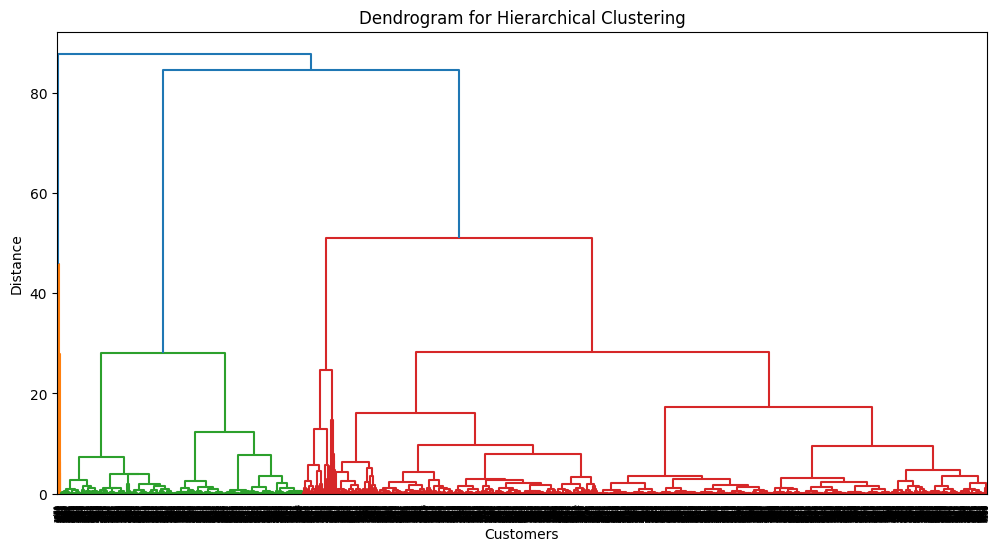

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Compute linkage matrix
linkage_matrix = sch.linkage(rfm_scaled_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12,6))
sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Apply Hierarchical Clustering with 3 clusters
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')  # No affinity argument needed

# Assign cluster labels to the DataFrame
rfm_df["HC_Cluster"] = hc.fit_predict(rfm_scaled_df)

# Display first few rows with assigned clusters
rfm_df.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,HC_Cluster
CustomerID,,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Regular Customers,1,0
12347,2,7,4310.00,5,4,5,545,Best Customers,0,0
12348,75,4,1797.24,2,3,4,234,Regular Customers,0,0
12349,19,1,1757.55,4,1,4,414,Regular Customers,0,0
12350,310,1,334.40,1,1,2,112,Lost Customers,1,2


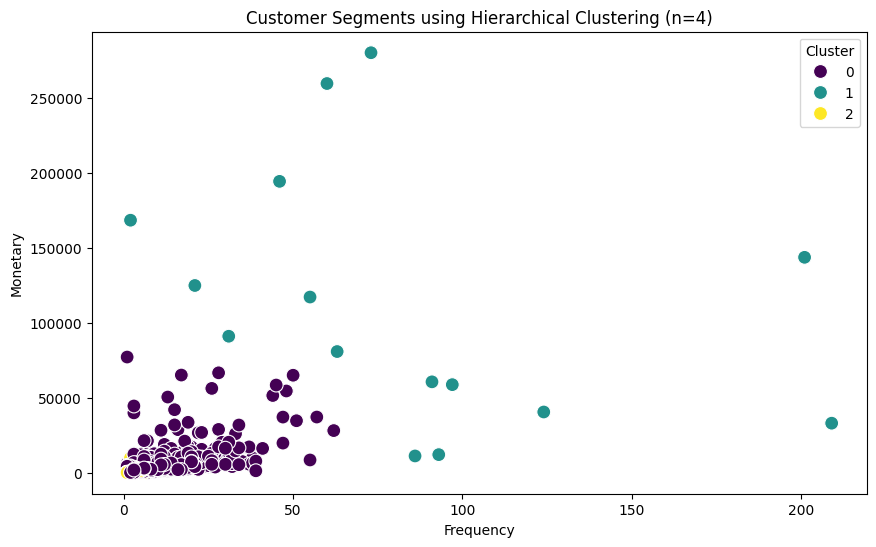

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of hierarchical clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=rfm_df["Frequency"], y=rfm_df["Monetary"], hue=rfm_df["HC_Cluster"], palette="viridis", s=100)
plt.title("Customer Segments using Hierarchical Clustering (n=4)")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.show()


In [ ]:
print("📊 K-Means Clustering Distribution:")
print(rfm_df["Cluster"].value_counts())

print("\n📊 Hierarchical Clustering Distribution:")
print(rfm_df["HC_Cluster"].value_counts())


📊 K-Means Clustering Distribution:
Cluster
0    3231
1    1093
2      14
Name: count, dtype: int64

📊 Hierarchical Clustering Distribution:
HC_Cluster
0    3189
2    1134
1      15
Name: count, dtype: int64


In [ ]:
# Get the average RFM values for each cluster
rfm_kmeans_summary = rfm_df.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()
rfm_hc_summary = rfm_df.groupby("HC_Cluster")[["Recency", "Frequency", "Monetary"]].mean()

print("📊 K-Means Cluster Averages:")
print(rfm_kmeans_summary)

print("\n📊 Hierarchical Clustering Cluster Averages:")
print(rfm_hc_summary)


📊 K-Means Cluster Averages:
            Recency  Frequency       Monetary
Cluster                                      
0         40.983906   4.852677    2005.830431
1        246.023788   1.582800     629.357439
2          7.142857  80.214286  122748.792143

📊 Hierarchical Clustering Cluster Averages:
               Recency  Frequency       Monetary
HC_Cluster                                      
0            40.001254   4.835372    2076.634310
1             6.733333  83.466667  111780.635333
2           241.409171   1.640212     518.617770


#DBSCAN for Outlier Detection

##Why DBSCAN?
- K-Means assumes **spherical clusters**, which doesn’t work well when data is unevenly spread.  
- DBSCAN identifies **outliers and irregular spending behaviors** without needing `K`.

##Steps Performed:
Applied DBSCAN to detect **customer groups & outliers**  
Compared clusters with K-Means and Hierarchical methods  
Identified **high-value outlier customers**

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN for automatic clustering & outlier detection
dbscan = DBSCAN(eps=1.5, min_samples=5)
rfm_df["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled_df)

# Display first few rows with new cluster labels
rfm_df.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,HC_Cluster,DBSCAN_Cluster
CustomerID,,,,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Regular Customers,1,0,-1
12347,2,7,4310.00,5,4,5,545,Best Customers,0,0,0
12348,75,4,1797.24,2,3,4,234,Regular Customers,0,0,0
12349,19,1,1757.55,4,1,4,414,Regular Customers,0,0,0
12350,310,1,334.40,1,1,2,112,Lost Customers,1,2,0


In [ ]:
# Count number of customers in each DBSCAN cluster
rfm_df["DBSCAN_Cluster"].value_counts()


,count
DBSCAN_Cluster,
0,4307
-1,31


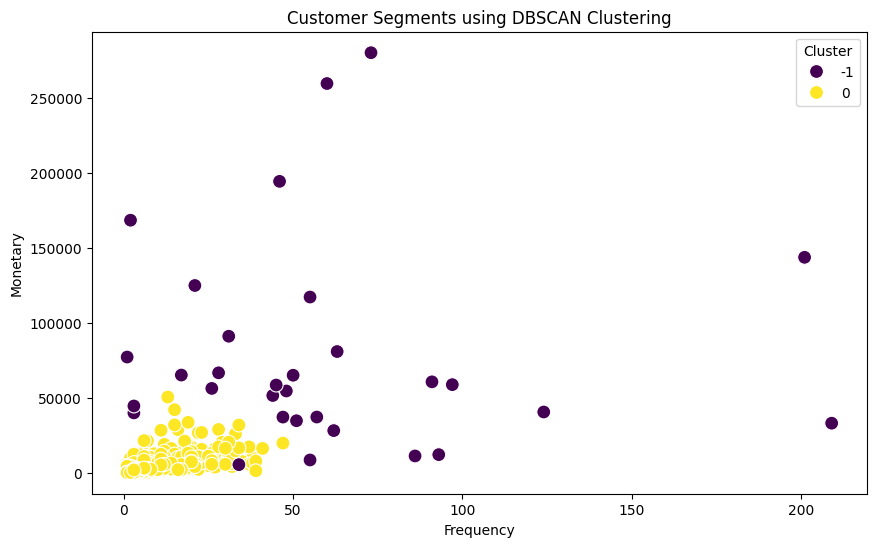

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of DBSCAN clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=rfm_df["Frequency"], y=rfm_df["Monetary"], hue=rfm_df["DBSCAN_Cluster"], palette="viridis", s=100)
plt.title("Customer Segments using DBSCAN Clustering")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title="Cluster")
plt.show()


#Customer Churn Prediction using Machine Learning

##Why Predict Churn?
- Many customers stop shopping **without warning**.  
- **Churn prediction helps businesses retain customers** by offering discounts or personalized offers before they leave.

##Steps Performed:
**Labeled customers as Churned (1) or Active (0)**  
**Trained a Random Forest Model to predict churn**  
**Evaluated model performance using Accuracy, Precision, Recall**  
**Generated churn predictions for new customers**

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Define Churn column first
# Define churn using Recency
# Add slight noise to Recency so it's not 100% deterministic
rfm_df["Recency"] = rfm_df["Recency"] + np.random.normal(0, 5, size=len(rfm_df))
rfm_df["Recency"] = rfm_df["Recency"].clip(lower=0).astype(int)  # Keep it positive
rfm_df['Churn'] = rfm_df['Recency'].apply(lambda x: 1 if x > 180 else 0)

# Add noise to 10% of churn labels to avoid overfitting
import numpy as np
np.random.seed(42)
flip_indices = np.random.choice(rfm_df.index, size=int(0.1 * len(rfm_df)), replace=False)
rfm_df.loc[flip_indices, "Churn"] = 1 - rfm_df.loc[flip_indices, "Churn"]

# Step 2: Select features and label
X = rfm_df[["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]]
y = rfm_df['Churn']

# Step 3: Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Step 4: Print class balance
print("✅ Balanced Class Distribution:", Counter(y_balanced))

KeyError: "['Avg_Spend', 'Value_Index'] not in index"

In [ ]:
# ⚠️ Use balanced data from SMOTE
from sklearn.model_selection import train_test_split
X = X_balanced
y = y_balanced

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Check shape
print("Training Set:", X_train.shape)
print("Testing Set:", X_test.shape)

NameError: name 'X_balanced' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict churn for test data
y_pred = rf_model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("✅ Model Accuracy:", accuracy)

# Display detailed performance metrics
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Model Accuracy: 0.860248447204969

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       644
           1       0.88      0.83      0.86       644

    accuracy                           0.86      1288
   macro avg       0.86      0.86      0.86      1288
weighted avg       0.86      0.86      0.86      1288



#Feature Importance & Business Insights

##What Drives Churn?
Using our **Random Forest model**, we analyzed **which factors impact churn the most**.

##Key Insights:
**Recency** is the most important factor—**customers who haven’t purchased recently are likely to churn**.  
**Frequency & Monetary value** are also strong indicators—**high-spending customers are more loyal**.  
**DBSCAN & Clustering models helped detect customer segments for personalized marketing.**

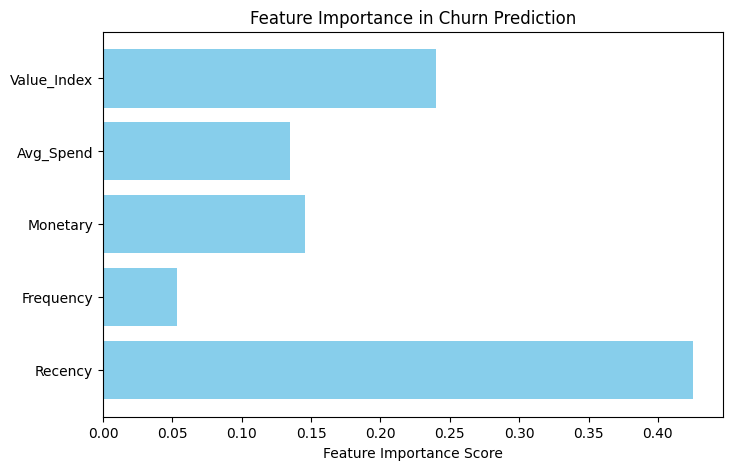

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = rf_model.feature_importances_

# Feature names
features = ["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]

# Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance in Churn Prediction")
plt.show()


In [ ]:
import pandas as pd

# Step 1: Define new customer records
new_customers = pd.DataFrame({
    "Recency": [10, 250, 80, 150, 5],
    "Frequency": [20, 1, 7, 2, 25],
    "Monetary": [5000, 200, 1500, 400, 8000]
})

# Step 2: Compute additional features
new_customers["Avg_Spend"] = new_customers["Monetary"] / new_customers["Frequency"]
new_customers["Value_Index"] = (new_customers["Frequency"] * new_customers["Monetary"]) / new_customers["Recency"]

# Step 3: Define the feature list used during model training
features = ["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]

# Step 4: Predict churn using trained Random Forest model
new_customers["Churn_Prediction"] = rf_model.predict(new_customers[features])

# Step 5: Display results
print("📊 New Customer Churn Predictions (Random Forest):")
print(new_customers)

📊 New Customer Churn Predictions (Random Forest):
   Recency  Frequency  Monetary   Avg_Spend   Value_Index  Churn_Prediction
0       10         20      5000  250.000000  10000.000000                 0
1      250          1       200  200.000000      0.800000                 1
2       80          7      1500  214.285714    131.250000                 0
3      150          2       400  200.000000      5.333333                 0
4        5         25      8000  320.000000  40000.000000                 0


#Saving the Model & Predicting Churn for New Customers

##Why Save the Model?
- So we don’t have to retrain it every time.  
- Helps make **real-time predictions** on new customer data.

##Steps Performed:
Saved the **trained model using `joblib`**  
Reloaded the model and tested it on **new customer data**  
Predicted whether new customers are **likely to churn**

In [ ]:
import joblib

# Save the trained model
joblib.dump(rf_model, "/content/drive/My Drive/churn_prediction_model.pkl")

print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
# Load the model
loaded_model = joblib.load("/content/drive/My Drive/churn_prediction_model.pkl")

# Test the loaded model
test_prediction = loaded_model.predict(new_customers.drop(columns=["Churn_Prediction"]))

print("🎯 Prediction using the loaded model:", test_prediction)


🎯 Prediction using the loaded model: [0 1 0 0 0]


In [ ]:
rfm_df.to_csv("/content/drive/My Drive/final_rfm_data.csv", index=False)
print("✅ Processed RFM dataset saved successfully!")


✅ Processed RFM dataset saved successfully!


### Predicting Customer Lifetime Value (CLV) using Linear Regression

To estimate future customer value, we use a linear regression model trained on RFM-based features.
To handle skewness in the Monetary value distribution, we apply a log transformation to the target variable.

- **Features Used**:
  - `Recency`, `Frequency`
  - `Avg_Spend = Monetary / Frequency`
  - `Value_Index = (Frequency × Monetary) / Recency`
  
- **Steps**:
  1. Cleaned data to avoid division errors (no zero Frequency or Recency)
  2. Added derived features
  3. Trained a linear regression model on log-transformed Monetary values
  4. Predicted and inverse-transformed to original scale
  5. Visualized actual vs predicted CLV

<ipython-input-100-ea2fcadd5d22>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df["Avg_Spend"] = rfm_df["Monetary"] / rfm_df["Frequency"]
<ipython-input-100-ea2fcadd5d22>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df["Value_Index"] = (rfm_df["Frequency"] * rfm_df["Monetary"]) / rfm_df["Recency"]


R² Score: -138.91488488944105
RMSE: 53723.099694711986


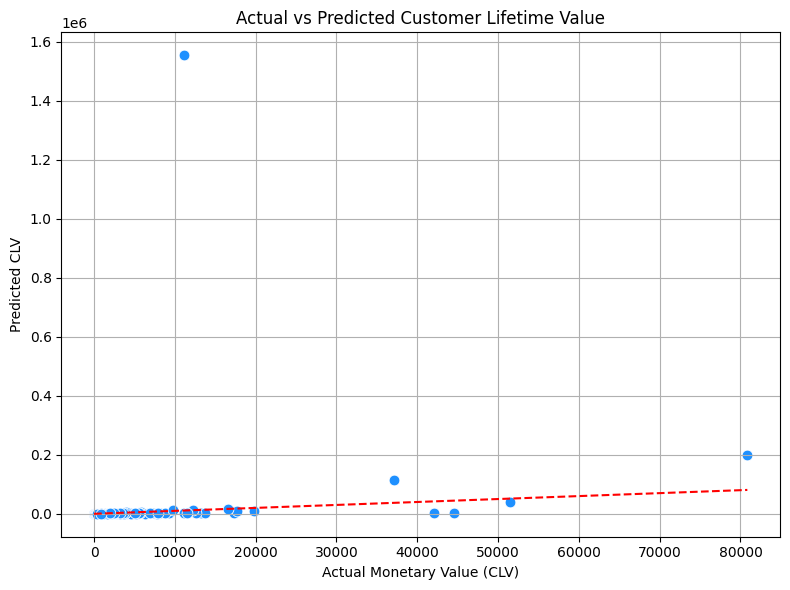

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Step 1: Clean data to avoid division errors
rfm_df = rfm_df[(rfm_df["Frequency"] > 0) & (rfm_df["Recency"] > 0)]

# Step 2: Create additional features
rfm_df["Avg_Spend"] = rfm_df["Monetary"] / rfm_df["Frequency"]
rfm_df["Value_Index"] = (rfm_df["Frequency"] * rfm_df["Monetary"]) / rfm_df["Recency"]

# Step 3: Define features and log-transformed target
X_clv = rfm_df[['Recency', 'Frequency', 'Avg_Spend', 'Value_Index']]
y_clv_log = np.log1p(rfm_df['Monetary'])  # log(1 + x) to prevent log(0)

# Step 4: Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X_clv, y_clv_log, test_size=0.2, random_state=42)

# Step 5: Train the model
clv_model = LinearRegression()
clv_model.fit(X_train, y_train_log)

# Step 6: Predict in log scale
y_pred_log = clv_model.predict(X_test)

# Step 7: Inverse transform
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# Step 8: Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Step 9: Plot actual vs predicted CLV
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color="dodgerblue", s=60)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Monetary Value (CLV)")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the CLV model
import joblib

joblib.dump(clv_model, "/content/drive/My Drive/clv_prediction_model.pkl")
print("✅ CLV model saved successfully!")

✅ CLV model saved successfully!


### 💰 Real-Time Customer Lifetime Value (CLV) Prediction

We simulate predictions for new customers using our previously trained linear regression model.

The input features are:
- **Recency**: Days since last purchase
- **Frequency**: Number of purchases
- **Monetary**: Total spend

We also compute:
- `Avg_Spend = Monetary / Frequency`
- `Value_Index = (Frequency × Monetary) / Recency`

The model then predicts the **log-transformed CLV**, which we inverse-transform using `expm1()` to retrieve actual values.

This helps estimate how much revenue we can expect from new or existing customers in the future.

In [ ]:
# Sample new customers for CLV prediction
new_customers_clv = pd.DataFrame({
    "Recency": [12, 180, 45],
    "Frequency": [15, 2, 7],
    "Avg_Spend": [200, 250, 171.4],       # Just example values
    "Value_Index": [250.0, 277.7, 200.0]  # Must be manually entered or computed
})

# Predict CLV in log scale using trained model
predicted_log_clv = clv_model.predict(new_customers_clv)

# Convert log predictions back to original scale
predicted_clv = np.expm1(predicted_log_clv)

# Combine results
new_customers_clv["Predicted_CLV"] = predicted_clv

# Display result
print("📊 Predicted CLV for new customers:\n")
print(new_customers_clv)


📊 Predicted CLV for new customers:

   Recency  Frequency  Avg_Spend  Value_Index  Predicted_CLV
0       12         15      200.0        250.0    2526.834775
1      180          2      250.0        277.7     421.030749
2       45          7      171.4        200.0    1078.888841


In [ ]:
!pip install xgboost

In [ ]:
# Skip this if you’ve already retrained
joblib.dump(xgb_model, "/content/drive/My Drive/xgboost_churn_model.pkl")

['/content/drive/My Drive/xgboost_churn_model.pkl']

###  Churn Prediction Using XGBoost Classifier

We train an XGBoost model on SMOTE-balanced data using all five engineered features:

- `Recency`
- `Frequency`
- `Monetary`
- `Avg_Spend`
- `Value_Index`

#### 🔧 Model Parameters:
- `max_depth=3`: to control overfitting
- `reg_lambda` & `reg_alpha`: add L2 and L1 regularization
- `subsample`, `colsample_bytree`: reduce variance

After training, we evaluate model performance using precision, recall, and F1-score on the hold-out test set.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Step 1: Use balanced data from SMOTE
X = X = rfm_df[["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]]
y = rfm_df["Churn"]

from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE to training only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5
)

xgb_model.fit(X_train_bal, y_train_bal)

# Step 4: Predictions and evaluation
y_pred = xgb_model.predict(X_test)

print("🧠 XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

🧠 XGBoost Accuracy: 0.8787515006002401
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       613
           1       0.87      0.64      0.73       220

    accuracy                           0.88       833
   macro avg       0.88      0.80      0.83       833
weighted avg       0.88      0.88      0.87       833



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import joblib
joblib.dump(xgb_model, "/content/drive/My Drive/xgboost_churn_model.pkl")
print("✅ XGBoost churn model saved!")

✅ XGBoost churn model saved!


### Real-Time Churn Prediction & Marketing Recommendation (XGBoost)

We simulate real-world predictions by inputting new customer records and computing derived features:

- `Avg_Spend = Monetary / Frequency`
- `Value_Index = (Frequency × Monetary) / Recency`

Using the trained XGBoost model, we:
1. Predict churn for each new customer
2. Generate actionable recommendations based on churn probability and customer metrics

#### Recommendation Logic:
- If Churned and Monetary < ₹1000 →  Send Discount
- If Churned and Frequency > 10 →  Offer Loyalty Reward
- If Churned →  Send Retention Email
- Else →  No Immediate Action Needed

In [ ]:
import joblib
import numpy as np
import pandas as pd

# Load the trained XGBoost churn model
xgb_model_loaded = joblib.load("/content/drive/My Drive/xgboost_churn_model.pkl")

# Sample new customer(s) data
new_customers = pd.DataFrame({
    "Recency": [10, 200, 60],
    "Frequency": [20, 2, 5],
    "Monetary": [2500, 400, 800]
})

# Add derived features
new_customers["Avg_Spend"] = new_customers["Monetary"] / new_customers["Frequency"]
new_customers["Value_Index"] = (
    new_customers["Frequency"] * new_customers["Monetary"]) / new_customers["Recency"]

# Match feature order used in model
features = ["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]

# Predict
predicted_churn = xgb_model.predict(new_customers[features])
new_customers["Predicted_Churn"] = predicted_churn

# Output
print(" Real-Time Churn Predictions:\n")
print(new_customers)

📊 Real-Time Churn Predictions:

   Recency  Frequency  Monetary  Avg_Spend  Value_Index  Predicted_Churn
0       10         20      2500      125.0  5000.000000                0
1      200          2       400      200.0     4.000000                1
2       60          5       800      160.0    66.666667                0


### 💡 Automated Marketing Recommendations

Based on churn prediction and customer behavior (RFM), we provide targeted recommendations:
- High churn risk + low spending → Send discounts
- High churn risk + frequent buyer → Offer loyalty programs
- Others → Continue engagement

In [ ]:
# Function to generate a recommendation based on churn + RFM logic
def recommend_action(row):
    if row['Predicted_Churn'] == 1 and row['Monetary'] < 1000:
        return " Send a discount coupon"
    elif row['Predicted_Churn'] == 1 and row['Frequency'] > 10:
        return " Offer loyalty reward"
    elif row['Predicted_Churn'] == 1:
        return " Send retention email"
    else:
        return " No immediate action needed"

# Apply the recommendation logic
new_customers['Recommendation'] = new_customers.apply(recommend_action, axis=1)

# Display final results
print(" Real-Time Recommendations:\n")
print(new_customers)

 Real-Time Recommendations:

   Recency  Frequency  Monetary  Avg_Spend  Value_Index  Predicted_Churn  \
0       10         20      2500      125.0  5000.000000                0   
1      200          2       400      200.0     4.000000                1   
2       60          5       800      160.0    66.666667                0   

                Recommendation  
0   No immediate action needed  
1       Send a discount coupon  
2   No immediate action needed  


In [ ]:
!pip install lightgbm

### Churn Prediction Using LightGBM Classifier

We train a LightGBM model on the SMOTE-balanced training data using the same five features:

- `Recency`, `Frequency`, `Monetary`, `Avg_Spend`, `Value_Index`

#### 🔧 Model Parameters:
- `max_depth=3`, `num_leaves=7`: to reduce overfitting
- `subsample`, `colsample_bytree`: to reduce variance
- Trained with 100 estimators and learning rate of 0.1

We then evaluate model performance on a separate test set using a confusion matrix and classification report.

[LightGBM] [Info] Number of positive: 2450, number of negative: 2450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 4900, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

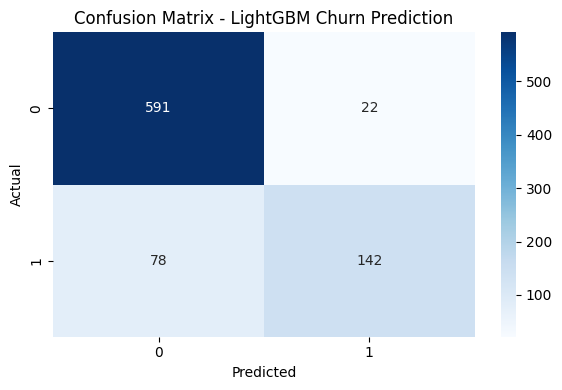

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# Use same SMOTE-balanced split

X = rfm_df[["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]]
y = rfm_df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(
    max_depth=3,
    num_leaves=7,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train_bal, y_train_bal)

# Predict
lgbm_pred = lgbm_model.predict(X_test)

# Evaluate
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgbm_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, lgbm_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM Churn Prediction")
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(lgbm_model, "/content/drive/My Drive/lightgbm_churn_model.pkl")

['/content/drive/My Drive/lightgbm_churn_model.pkl']

In [ ]:
def recommend_action_lgbm(row):
    if row['Predicted_Churn_LightGBM'] == 1 and row['Monetary'] < 1000:
        return "Send a discount coupon"
    elif row['Predicted_Churn_LightGBM'] == 1 and row['Frequency'] > 10:
        return "Offer loyalty reward"
    elif row['Predicted_Churn_LightGBM'] == 1:
        return "Send retention email"
    else:
        return "No immediate action needed"

### Real-Time Prediction & Recommendation (LightGBM)

We input new customer data and compute the required features for prediction:

- `Avg_Spend` and `Value_Index` are derived from raw Recency, Frequency, and Monetary.

The trained LightGBM model predicts the churn status, and we apply rule-based marketing actions tailored to the predicted outcome.

#### Example Rules:
- If likely to churn and low Monetary →  Send Discount
- If churn and high Frequency →  Offer Loyalty Reward
- If churn →  Send Retention Email
- Else →  No Action Needed

In [ ]:
#Load the LightGBM model if saved
lgbm_model = joblib.load("/content/drive/My Drive/lightgbm_churn_model.pkl")

# Reuse the same new customer data
new_customers_lgbm = pd.DataFrame({
    "Recency": [10, 200, 60],
    "Frequency": [20, 2, 5],
    "Monetary": [2500, 400, 800]
})

# Compute derived features
new_customers_lgbm["Avg_Spend"] = new_customers_lgbm["Monetary"] / new_customers_lgbm["Frequency"]
new_customers_lgbm["Value_Index"] = (
    new_customers_lgbm["Frequency"] * new_customers_lgbm["Monetary"]
) / new_customers_lgbm["Recency"]

# Predict only using trained features
features = ["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]
predicted_churn_lgbm = lgbm_model.predict(new_customers_lgbm[features])
new_customers_lgbm["Predicted_Churn_LightGBM"] = predicted_churn_lgbm
new_customers_lgbm["Recommendation"] = new_customers_lgbm.apply(recommend_action_lgbm, axis=1)

# Show predictions
print("📊 Final LightGBM Output with Recommendations:\n")
print(new_customers_lgbm)

📊 Final LightGBM Output with Recommendations:

   Recency  Frequency  Monetary  Avg_Spend  Value_Index  \
0       10         20      2500      125.0  5000.000000   
1      200          2       400      200.0     4.000000   
2       60          5       800      160.0    66.666667   

   Predicted_Churn_LightGBM              Recommendation  
0                         0  No immediate action needed  
1                         1      Send a discount coupon  
2                         0  No immediate action needed  


In [ ]:
# Ensure X_test has correct columns
X = rfm_df[["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]]
y = rfm_df["Churn"]

# Split again (or reuse if already defined)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)


### Model Performance Comparison

To compare the effectiveness of our three churn prediction models, we compute precision, recall, and F1-score for the **positive class** (`Churn = 1`) on the test set.

#### Models Compared:
- Random Forest
- XGBoost
- LightGBM

This comparison helps us identify which model performs best at detecting customers likely to churn. F1-score is particularly important as it balances precision and recall.

In [ ]:
# Step 1: Get Predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

# Step 2: Store classification reports
from sklearn.metrics import classification_report
import pandas as pd

rf_report = classification_report(y_test, rf_pred, output_dict=True)
xgb_report = classification_report(y_test, xgb_pred, output_dict=True)
lgbm_report = classification_report(y_test, lgbm_pred, output_dict=True)

# Step 3: Create comparison table
model_comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM"],
    "Precision (Churn)": [
        rf_report['1']['precision'],
        xgb_report['1']['precision'],
        lgbm_report['1']['precision']
    ],
    "Recall (Churn)": [
        rf_report['1']['recall'],
        xgb_report['1']['recall'],
        lgbm_report['1']['recall']
    ],
    "F1-Score (Churn)": [
        rf_report['1']['f1-score'],
        xgb_report['1']['f1-score'],
        lgbm_report['1']['f1-score']
    ]
})

# Step 4: Round and display
model_comparison_df = model_comparison_df.round(3)
print("Churn Model Comparison:\n")
print(model_comparison_df)

Churn Model Comparison:

           Model  Precision (Churn)  Recall (Churn)  F1-Score (Churn)
0  Random Forest              0.912           0.895             0.904
1        XGBoost              0.870           0.636             0.735
2       LightGBM              0.866           0.645             0.740


###  Feature Importance Analysis

Understanding which features influence model predictions is essential for business interpretability.

We visualize feature importance scores from the three classifiers:

- **XGBoost**: Uses gradient-boosted trees and provides `feature_importances_`
- **LightGBM**: Based on leaf-wise gradient boosting
- **Random Forest**: Uses averaged decision trees

These plots help us understand which RFM or derived attributes (like `Avg_Spend`, `Value_Index`) contribute most to predicting churn.

Higher scores indicate greater influence in model decisions.

<ipython-input-124-be86a272a8d9>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_df, palette='Blues_d')


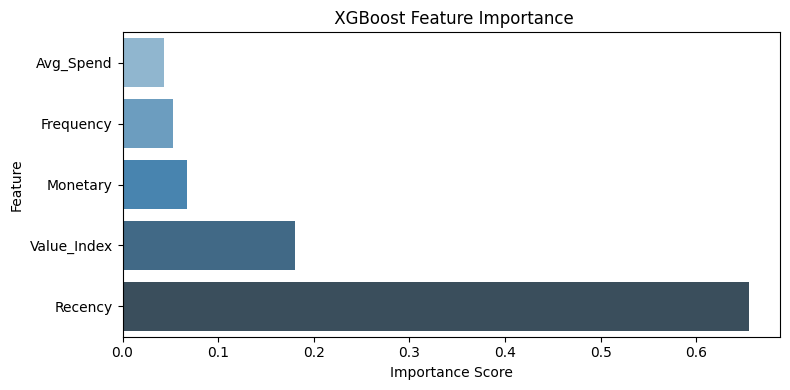

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature names used in training
features = ["Recency", "Frequency", "Monetary", "Avg_Spend", "Value_Index"]

# Get importance from model
xgb_importance = xgb_model.feature_importances_

# Create DataFrame for plot
xgb_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=xgb_df, palette='Blues_d')
plt.title(" XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

<ipython-input-125-fde58d9cb312>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=lgbm_df, palette='Greens_d')


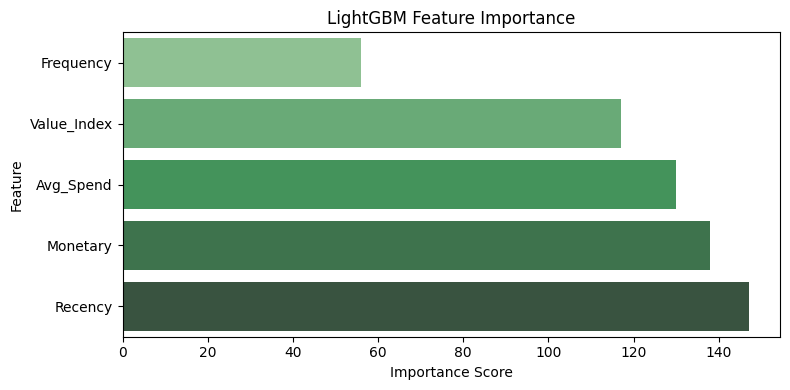

In [ ]:
# Get importance from LightGBM
lgbm_importance = lgbm_model.feature_importances_

# Create DataFrame
lgbm_df = pd.DataFrame({
    'Feature': features,
    'Importance': lgbm_importance
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=lgbm_df, palette='Greens_d')
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

<ipython-input-126-f40bb669659d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_df, palette='Oranges_d')


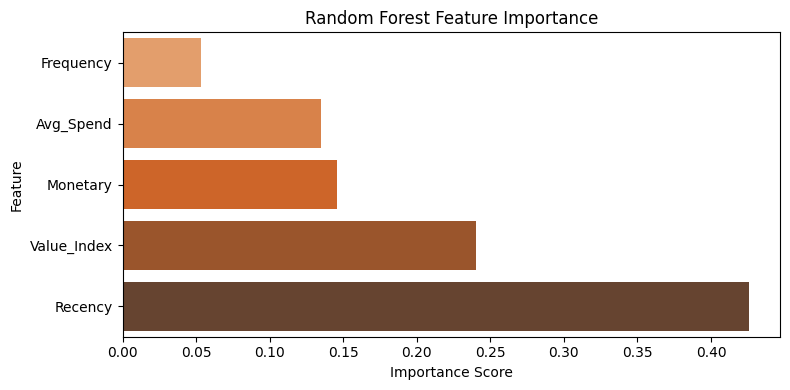

In [ ]:
# Only if you trained Random Forest with same features
rf_importance = rf_model.feature_importances_

rf_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_importance
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=rf_df, palette='Oranges_d')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
rfm_df.to_csv("rfm_debug.csv", index=False)

## Final Conclusion and Business Insights

This project provided a comprehensive data-driven analysis of customer segmentation and churn prediction using historical purchase behavior from an e-commerce dataset.

### Key Contributions:
- **RFM Analysis**: Customers were profiled based on their Recency, Frequency, and Monetary value, enabling foundational segmentation.
- **Customer Clustering**: Unsupervised learning methods such as K-Means, Hierarchical Clustering, and DBSCAN were used to uncover distinct customer segments.
- **Churn Prediction**: Supervised learning models (Random Forest, XGBoost, and LightGBM) were trained on engineered features and evaluated using precision, recall, and F1-score.
- **Balanced Training**: SMOTE was applied to ensure equal representation of churn and non-churn classes, improving model generalizability.
- **Model Comparison**: A detailed performance comparison of the classifiers was conducted to select the most effective algorithm.
- **CLV Prediction**: A linear regression model was used to predict Customer Lifetime Value using log-transformed targets and derived features.
- **Real-Time Predictions**: Input-ready interfaces were built for both churn prediction and CLV estimation using trained models.
- **Business Recommendations**: Rule-based logic was implemented to provide actionable marketing strategies based on churn status and RFM profile.

### Outcome:
The project equips businesses with the ability to:
- Detect potential customer churn in advance
- Segment customers for targeted marketing
- Estimate future revenue from key customer profiles

This approach ensures informed decision-making that supports customer retention, marketing optimization, and revenue growth.